In [55]:
import os
import zipfile
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score


In [56]:
# Define transformations for data preprocessing
transform = transforms.Compose([
    #transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [57]:

train_dataset = ImageFolder('train_data_extracted', transform=transform)
test_dataset = ImageFolder('test_data_extracted', transform=transform)
valid_dataset = ImageFolder('valid_data_extracted', transform=transform)

In [58]:

# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [59]:
from PIL import Image

# Open the image
image = Image.open("image.JPEG")

# Get the resolution
width, height = image.size

print("Width:", width)
print("Height:", height)


Width: 224
Height: 224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


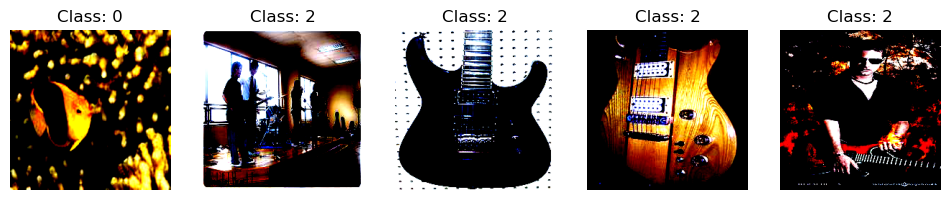

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for ax, image, label in zip(axes, images, labels):
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        ax.set_title(f'Class: {label}')
        ax.axis('off')
    plt.show()

# Get a batch of data from the DataLoader
for images, labels in train_loader:
    break

# Display sample images and labels
show_images(images[:5], labels[:5])


In [63]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes, cl2_feature_maps, hidden_size1, hidden_size2):
        super(CNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1)
        # Pooling Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=cl2_feature_maps, kernel_size=3, stride=1, padding=1)
        # Pooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully Connected Layer
        self.fc = nn.Linear(cl2_feature_maps * 56 * 56, hidden_size1)  # Assuming input size after pooling is 56x56
        # Hidden Layer 1
        self.hidden1 = nn.Linear(hidden_size1, hidden_size2)
        # Hidden Layer 2
        self.hidden2 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        # Forward pass
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc(x))
        x = torch.relu(self.hidden1(x))
        x = self.hidden2(x)
        return x


In [66]:
for i in range(2,3):  # Assuming you want to loop over feature maps from 4 to 8
    print(f"***    {i}   ********")
    # Create model instance
    num_classes = len(train_dataset.classes)
    cl2_feature_maps = i
    hidden_size1 = 128  # Size for the first hidden layer
    hidden_size2 = 25  # Size for the second hidden layer
    model = CNN(num_classes, cl2_feature_maps, hidden_size1, hidden_size2)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Function to calculate accuracy
    def calculate_accuracy(loader):
        model.eval()  # Set the model to evaluation mode
        correct = 0
        total = 0
        predictions = []
        true_labels = []
        with torch.no_grad():
            for images, labels in loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                predictions.extend(predicted.numpy())
                true_labels.extend(labels.numpy())
        accuracy = correct / total
        return accuracy, np.array(predictions), np.array(true_labels)

    # Training the model
    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

    # Calculate training, validation, and test accuracies
    train_accuracy, train_predictions, train_labels = calculate_accuracy(train_loader)
    valid_accuracy, valid_predictions, valid_labels = calculate_accuracy(valid_loader)
    test_accuracy, test_predictions, test_labels = calculate_accuracy(test_loader)

    print(f"Training Accuracy: {train_accuracy}")
    print(f"Validation Accuracy: {valid_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix

    train_confusion_matrix = confusion_matrix(train_labels, train_predictions)
    valid_confusion_matrix = confusion_matrix(valid_labels, valid_predictions)
    test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

    print("Confusion Matrix (Training):")
    print(train_confusion_matrix)
    print("Confusion Matrix (Validation):")
    print(valid_confusion_matrix)
    print("Confusion Matrix (Test):")
    print(test_confusion_matrix)
    print("**********************************************************************************************")

***    2   ********
Epoch [1/10], Loss: 1.4403167262909904
Epoch [2/10], Loss: 1.1571420232454936
Epoch [3/10], Loss: 1.047252823436071
Epoch [4/10], Loss: 0.9542583861048259
Epoch [5/10], Loss: 0.8422908309906249
Epoch [6/10], Loss: 0.7062139799670567
Epoch [7/10], Loss: 0.5860990011502826
Epoch [8/10], Loss: 0.4446184824383448
Epoch [9/10], Loss: 0.2927498671980131
Epoch [10/10], Loss: 0.24827921343228174
Training Accuracy: 0.958
Validation Accuracy: 0.57
Test Accuracy: 0.602
Confusion Matrix (Training):
[[394   2   3   1   0]
 [  0 399   1   0   0]
 [  1   2 396   0   1]
 [  1  23  20 348   8]
 [  1  18   2   0 379]]
Confusion Matrix (Validation):
[[64  9 15  2 10]
 [ 0 80  4  7  9]
 [ 9  8 61 11 11]
 [ 3 26 30 26 15]
 [ 1 15 16 14 54]]
Confusion Matrix (Test):
[[77  1 15  4  3]
 [ 1 79  5  5 10]
 [10  5 64  8 13]
 [ 5 23 32 23 17]
 [ 4 15 15  8 58]]
**********************************************************************************************


In [68]:
torch.save(model.state_dict(), f'CNN_model_{i}.pth')

In [70]:
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
model = torch.load('CNN_model_62.pth')  # Load your trained model

# Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming this is the size used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the JPEG image
image = Image.open('image.JPEG')

# Apply transformations
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Pass through the model
with torch.no_grad():
    model.eval()
    output = model(input_image)

# Post-processing (optional)
probabilities = torch.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities).item()

# Get the predicted class label
predicted_label = train_dataset.classes[predicted_class]  # Assuming train_dataset is accessible
print(f"The predicted class is: {predicted_label}")


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'